# Multivariate Time Series Model of Coal Generation

In [359]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from datetime import datetime, timedelta

%matplotlib inline
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout

import warnings
warnings.simplefilter(action="ignore")

In [360]:
df = pd.read_csv('../../data/final_dfs/combined_final.csv')
temp_df = pd.read_csv('../../data/temperature/texas_temp.csv')

In [361]:
df.head()

,date,Biomass,Coal,Hydro,Nuclear,Other,Solar,Wind,NGas
0,2011-01-01,1240.848016,304483.8981,670.712237,90516.91023,357.449324,70.651290,123213.38820,248086.36399
1,2011-01-02,1478.590690,320703.6726,667.009668,90462.21494,372.626928,10.255158,62531.39844,268971.64998
2,2011-01-03,1483.246127,296436.2237,741.426017,90472.37075,401.536782,15.155827,89515.57352,222285.00985
3,2011-01-04,1411.010006,322214.6377,683.281626,90312.68708,478.415477,5.278214,59542.48570,271747.93685
4,2011-01-05,1348.331266,308136.0801,623.145421,90280.19160,440.383112,22.997359,128920.84250,358001.80005


In [362]:
temp_df.head()

,Date,Temp
0,1/1/11,45.0
1,2/1/11,48.7
2,3/1/11,61.8
3,4/1/11,70.3
4,5/1/11,74.1


In [363]:
df = df[['date', 'NGas']]

In [364]:
df['date']=pd.to_datetime(df['date'])

In [365]:
df = df[df['date'].dt.day == 1]

In [366]:
df.reset_index(inplace=True)

In [367]:
df.drop(columns='index',inplace=True)

In [368]:
df_full = pd.concat([df, temp_df], axis =1)

In [369]:
df_full

,date,NGas,Date,Temp
0,2011-01-01,248086.363990,1/1/11,45.0
1,2011-02-01,218819.159530,2/1/11,48.7
2,2011-03-01,343441.973030,3/1/11,61.8
3,2011-04-01,202053.382820,4/1/11,70.3
4,2011-05-01,472446.061500,5/1/11,74.1
...,...,...,...,...
115,2020-08-01,721716.604984,8/1/20,84.3
116,2020-09-01,651271.628603,9/1/20,74.0
117,2020-10-01,445206.272739,10/1/20,65.9
118,2020-11-01,347772.901358,11/1/20,60.6


In [370]:
train_dates = pd.to_datetime(df['date'])
df_full.drop(columns='Date',inplace=True)
#df_full.set_index('date', inplace=True)

In [371]:
df_full

,date,NGas,Temp
0,2011-01-01,248086.363990,45.0
1,2011-02-01,218819.159530,48.7
2,2011-03-01,343441.973030,61.8
3,2011-04-01,202053.382820,70.3
4,2011-05-01,472446.061500,74.1
...,...,...,...
115,2020-08-01,721716.604984,84.3
116,2020-09-01,651271.628603,74.0
117,2020-10-01,445206.272739,65.9
118,2020-11-01,347772.901358,60.6


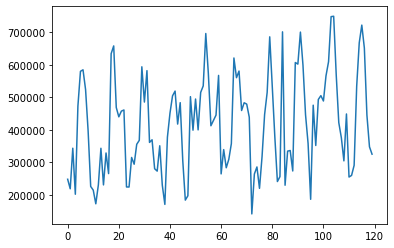

In [372]:
plt.plot(df_full['NGas'])

### Because Natural Gas and Temperautre are on such different scales, let's apply a standard scaler

In [373]:
cols = list(df_full)[1:3]

In [374]:
df_train = df_full[cols].astype(float)

In [375]:
sc = StandardScaler()
sc = sc.fit(df_train)
df_sc = sc.transform(df_train)

### Create our train and prediction series

In [376]:
trainX = []
trainY = []

n_future = 1
n_past = 14

for i in range(n_past, len(df_sc) - n_future +1):
    trainX.append(df_sc[i - n_past:i, 0:df_train.shape[1]])
    trainY.append(df_sc[i + n_future - 1:i + n_future, 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (106, 14, 2).
trainY shape == (106, 1).


In [377]:
trainX

array([[[-1.12942114, -1.61420448],
        [-1.32527477, -1.33516738],
        [-0.49130952, -0.34722522],
        ...,
        [-1.63399511, -1.5312475 ],
        [-1.24621354, -1.20696114],
        [-0.49236218, -1.10137954]],

       [[-1.32527477, -1.33516738],
        [-0.49130952, -0.34722522],
        [-1.43746992,  0.29380595],
        ...,
        [-1.24621354, -1.20696114],
        [-0.49236218, -1.10137954],
        [-1.24524301, -0.24164361]],

       [[-0.49130952, -0.34722522],
        [-1.43746992,  0.29380595],
        [ 0.37197484,  0.5803846 ],
        ...,
        [-0.49236218, -1.10137954],
        [-1.24524301, -0.24164361],
        [-0.58927017,  0.28626441]],

       ...,

       [[ 2.21405282,  1.47028669],
        [ 2.22217694,  1.13845879],
        [ 1.01714583, -0.09081275],
        ...,
        [ 1.675883  ,  1.41749589],
        [ 2.04007208,  1.349622  ],
        [ 1.5686603 ,  0.57284305]],

       [[ 2.22217694,  1.13845879],
        [ 1.01714583, -0.09

### Instantiate and Fit our Model

In [343]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 14, 64)            17152     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 29,601
Trainable params: 29,601
Non-trainable params: 0
_________________________________________________________________


In [344]:
history= model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
6/6 [==============================] - 3s 101ms/step - loss: 0.8167 - val_loss: 1.2251
Epoch 2/10
6/6 [==============================] - 0s 19ms/step - loss: 0.9753 - val_loss: 1.2173
Epoch 3/10
6/6 [==============================] - 0s 22ms/step - loss: 0.9069 - val_loss: 1.2063
Epoch 4/10
6/6 [==============================] - 0s 25ms/step - loss: 0.8934 - val_loss: 1.1874
Epoch 5/10
6/6 [==============================] - 0s 21ms/step - loss: 0.9483 - val_loss: 1.1589
Epoch 6/10
6/6 [==============================] - 0s 22ms/step - loss: 0.8373 - val_loss: 1.1179
Epoch 7/10
6/6 [==============================] - 0s 19ms/step - loss: 0.7426 - val_loss: 1.0042
Epoch 8/10
6/6 [==============================] - 0s 19ms/step - loss: 0.7309 - val_loss: 0.7979
Epoch 9/10
6/6 [==============================] - 0s 21ms/step - loss: 0.6509 - val_loss: 0.4999
Epoch 10/10
6/6 [==============================] - 0s 29ms/step - loss: 0.5163 - val_loss: 0.6491


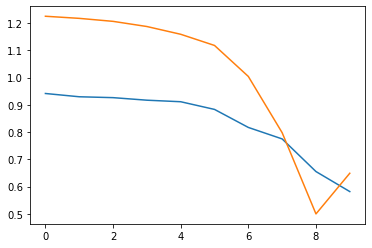

In [345]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

In [346]:
n_forecast = 24  # period length of forecasts - in this case, months

# create a list of dates based on training dates, start at first training date and create list of length n_forecast
forecast_period_dates = pd.date_range(start=list(train_dates)[-1], periods=n_forecast, freq='MS').tolist()   

In [347]:
forecast_period_dates

[Timestamp('2020-12-01 00:00:00', freq='MS'),
 Timestamp('2021-01-01 00:00:00', freq='MS'),
 Timestamp('2021-02-01 00:00:00', freq='MS'),
 Timestamp('2021-03-01 00:00:00', freq='MS'),
 Timestamp('2021-04-01 00:00:00', freq='MS'),
 Timestamp('2021-05-01 00:00:00', freq='MS'),
 Timestamp('2021-06-01 00:00:00', freq='MS'),
 Timestamp('2021-07-01 00:00:00', freq='MS'),
 Timestamp('2021-08-01 00:00:00', freq='MS'),
 Timestamp('2021-09-01 00:00:00', freq='MS'),
 Timestamp('2021-10-01 00:00:00', freq='MS'),
 Timestamp('2021-11-01 00:00:00', freq='MS'),
 Timestamp('2021-12-01 00:00:00', freq='MS'),
 Timestamp('2022-01-01 00:00:00', freq='MS'),
 Timestamp('2022-02-01 00:00:00', freq='MS'),
 Timestamp('2022-03-01 00:00:00', freq='MS'),
 Timestamp('2022-04-01 00:00:00', freq='MS'),
 Timestamp('2022-05-01 00:00:00', freq='MS'),
 Timestamp('2022-06-01 00:00:00', freq='MS'),
 Timestamp('2022-07-01 00:00:00', freq='MS'),
 Timestamp('2022-08-01 00:00:00', freq='MS'),
 Timestamp('2022-09-01 00:00:00', 

In [348]:
# make predictions on our model based on the training data. Use  
forecast = model.predict(trainX[-n_forecast:])

In [349]:
forecast_copies = np.repeat(forecast, df_train.shape[1], axis=-1)


In [350]:
y_pred_future = sc.inverse_transform(forecast_copies)[:,0]  # Take

In [351]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [352]:
len(y_pred_future)

24

In [353]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'NGas':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [354]:
original = pd.DataFrame(df_full[['date', 'NGas']])


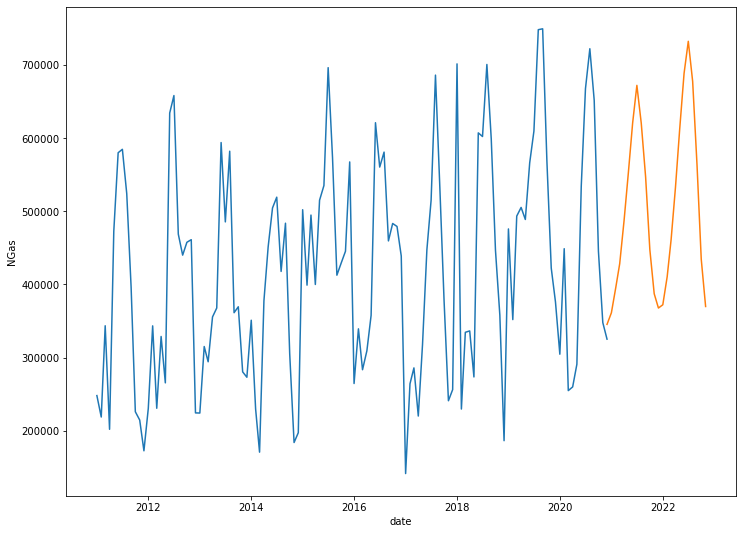

In [355]:
plt.figure(figsize=(12,9))
sns.lineplot(original['date'], original['NGas']);
sns.lineplot(df_forecast['Date'], df_forecast['NGas']);